In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import optimizers
from keras import metrics

2023-09-01 22:35:17.869474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 22:35:17.894843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 22:35:18.285480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv("lsa64_dataset_best_80_fps.csv")

In [3]:
frames = 80

In [4]:
def reshape_features_dataset(features):
    return features.reshape((int(features.shape[0]/frames), frames, features.shape[1]))

def reshape_target_dataset(target):
    return target.reshape((int(target.shape[0]/frames), frames))[:, 0]

In [5]:
data.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'category', 'video_name',
       'frame', 'hand_0_wrist_x', 'hand_0_wrist_y', 'hand_0_wrist_z',
       'hand_0_thumb_cmc_x',
       ...
       'pose_left_heel_y', 'pose_left_heel_z', 'pose_right_foot_index_x',
       'pose_right_foot_index_y', 'pose_right_foot_index_z',
       'pose_left_foot_index_x', 'pose_left_foot_index_y',
       'pose_left_foot_index_z', 'missing_hand', 'missing_face'],
      dtype='object', length=1631)

In [6]:
categories = list(data["category"].unique())

In [7]:
data["category_index"] = data["category"].apply(lambda i: categories.index(i))

In [8]:
columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2", "category", "category_index", "video_name", "frame", "missing_hand", "missing_face"]
predict_columns = "category_index"

In [9]:
# LOPO
data["person"] = data["video_name"].apply(lambda i: i.split("_")[1])
people = data["person"].unique()
validate_people = people[-2:]
test_people = people[-4:-2]
train_people = people[:-4]

train_dataset = data[data["person"].isin(train_people)]
test_dataset = data[data["person"].isin(test_people)]
validate_dataset = data[data["person"].isin(validate_people)]

train_features = train_dataset.drop(columns_to_drop + ["person"], axis=1).values
train_features = reshape_features_dataset(train_features)
train_target = train_dataset[predict_columns].values
train_target = reshape_target_dataset(train_target)

test_features = test_dataset.drop(columns_to_drop + ["person"], axis=1).values
test_features = reshape_features_dataset(test_features)
test_target = test_dataset[predict_columns].values
test_target = reshape_target_dataset(test_target)

validate_features = validate_dataset.drop(columns_to_drop + ["person"], axis=1).values
validate_features = reshape_features_dataset(validate_features)
validate_target = validate_dataset[predict_columns].values
validate_target = reshape_target_dataset(validate_target)

In [52]:
# Train test split
features = data.drop(columns_to_drop, axis=1).values
target = data[predict_columns].values

features = reshape_features_dataset(features)
target = reshape_target_dataset(target)

train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.4)

In [10]:
test_target.shape

(100,)

In [11]:
model = Sequential()
model.add(LSTM(64, input_shape=(frames, train_features.shape[2]), return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64))
model.add(Dropout(0.4))
model.add(Dense(32))
model.add(Dense(10, activation='softmax'))

2023-09-01 22:36:33.933458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-01 22:36:33.955133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-01 22:36:33.955266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-01 22:36:33.957078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-01 22:36:33.957215: I tensorflow/compile

In [12]:
# Compile the model
optimizer = optimizers.Adam(learning_rate=1e-5)
# optimizer = optimizers.SGD(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'sparse_categorical_accuracy'])

In [13]:
# Train the model
result = model.fit(train_features, train_target, epochs=1000, batch_size=32, validation_data=(validate_features, validate_target))

Epoch 1/1000


2023-09-01 22:36:37.222730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-01 22:36:37.224142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-01 22:36:37.224819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 6/10 [=================>............] - ETA: 0s - loss: 2.3045 - accuracy: 0.0677 - sparse_categorical_accuracy: 0.0677 

2023-09-01 22:36:39.633794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-01 22:36:39.634769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-01 22:36:39.635529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 3s 66ms/step - loss: 2.3045 - accuracy: 0.0967 - sparse_categorical_accuracy: 0.0967 - val_loss: 2.3006 - val_accuracy: 0.1000 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/1000
10/10 [==============================] - 0s 16ms/step - loss: 2.3025 - accuracy: 0.1033 - sparse_categorical_accuracy: 0.1033 - val_loss: 2.2981 - val_accuracy: 0.1000 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/1000
10/10 [==============================] - 0s 17ms/step - loss: 2.3018 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.2963 - val_accuracy: 0.1000 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/1000
10/10 [==============================] - 0s 16ms/step - loss: 2.2980 - accuracy: 0.1333 - sparse_categorical_accuracy: 0.1333 - val_loss: 2.2940 - val_accuracy: 0.1000 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/1000
10/10 [==============================] - 0s 16ms/step - loss: 2.2983 - accuracy: 0.1100 - sparse_categorical

Epoch 38/1000
10/10 [==============================] - 0s 17ms/step - loss: 1.9086 - accuracy: 0.3733 - sparse_categorical_accuracy: 0.3733 - val_loss: 1.9100 - val_accuracy: 0.4900 - val_sparse_categorical_accuracy: 0.4900
Epoch 39/1000
10/10 [==============================] - 0s 17ms/step - loss: 1.8722 - accuracy: 0.4267 - sparse_categorical_accuracy: 0.4267 - val_loss: 1.8663 - val_accuracy: 0.4800 - val_sparse_categorical_accuracy: 0.4800
Epoch 40/1000
10/10 [==============================] - 0s 17ms/step - loss: 1.8596 - accuracy: 0.3900 - sparse_categorical_accuracy: 0.3900 - val_loss: 1.8413 - val_accuracy: 0.4500 - val_sparse_categorical_accuracy: 0.4500
Epoch 41/1000
10/10 [==============================] - 0s 16ms/step - loss: 1.8196 - accuracy: 0.4233 - sparse_categorical_accuracy: 0.4233 - val_loss: 1.8112 - val_accuracy: 0.5000 - val_sparse_categorical_accuracy: 0.5000
Epoch 42/1000
10/10 [==============================] - 0s 16ms/step - loss: 1.8190 - accuracy: 0.3867 - 

10/10 [==============================] - 0s 16ms/step - loss: 1.3087 - accuracy: 0.5467 - sparse_categorical_accuracy: 0.5467 - val_loss: 1.3072 - val_accuracy: 0.5400 - val_sparse_categorical_accuracy: 0.5400
Epoch 75/1000
10/10 [==============================] - 0s 17ms/step - loss: 1.2913 - accuracy: 0.5033 - sparse_categorical_accuracy: 0.5033 - val_loss: 1.2886 - val_accuracy: 0.5800 - val_sparse_categorical_accuracy: 0.5800
Epoch 76/1000
10/10 [==============================] - 0s 16ms/step - loss: 1.2562 - accuracy: 0.5800 - sparse_categorical_accuracy: 0.5800 - val_loss: 1.2936 - val_accuracy: 0.5500 - val_sparse_categorical_accuracy: 0.5500
Epoch 77/1000
10/10 [==============================] - 0s 16ms/step - loss: 1.2427 - accuracy: 0.5333 - sparse_categorical_accuracy: 0.5333 - val_loss: 1.2670 - val_accuracy: 0.5700 - val_sparse_categorical_accuracy: 0.5700
Epoch 78/1000
10/10 [==============================] - 0s 17ms/step - loss: 1.2629 - accuracy: 0.5100 - sparse_categor

10/10 [==============================] - 0s 16ms/step - loss: 0.8762 - accuracy: 0.6967 - sparse_categorical_accuracy: 0.6967 - val_loss: 1.0080 - val_accuracy: 0.6300 - val_sparse_categorical_accuracy: 0.6300
Epoch 111/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.8834 - accuracy: 0.6933 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.9599 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 112/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.8665 - accuracy: 0.7067 - sparse_categorical_accuracy: 0.7067 - val_loss: 1.0398 - val_accuracy: 0.6300 - val_sparse_categorical_accuracy: 0.6300
Epoch 113/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.8582 - accuracy: 0.7067 - sparse_categorical_accuracy: 0.7067 - val_loss: 1.0174 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 114/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.8343 - accuracy: 0.7300 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.6000 - accuracy: 0.8300 - sparse_categorical_accuracy: 0.8300 - val_loss: 0.8359 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 147/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.5554 - accuracy: 0.8367 - sparse_categorical_accuracy: 0.8367 - val_loss: 0.8480 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 148/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.6312 - accuracy: 0.8033 - sparse_categorical_accuracy: 0.8033 - val_loss: 0.9975 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 149/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.5916 - accuracy: 0.7867 - sparse_categorical_accuracy: 0.7867 - val_loss: 0.8384 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 150/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.5254 - accuracy: 0.8667 - sparse_cat

10/10 [==============================] - 0s 18ms/step - loss: 0.3832 - accuracy: 0.9033 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.8822 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 183/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.4250 - accuracy: 0.9033 - sparse_categorical_accuracy: 0.9033 - val_loss: 1.0896 - val_accuracy: 0.6700 - val_sparse_categorical_accuracy: 0.6700
Epoch 184/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.3856 - accuracy: 0.9000 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.9942 - val_accuracy: 0.6500 - val_sparse_categorical_accuracy: 0.6500
Epoch 185/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.4751 - accuracy: 0.8400 - sparse_categorical_accuracy: 0.8400 - val_loss: 1.0552 - val_accuracy: 0.6300 - val_sparse_categorical_accuracy: 0.6300
Epoch 186/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.3975 - accuracy: 0.8933 - sparse_cat

10/10 [==============================] - 0s 18ms/step - loss: 0.3203 - accuracy: 0.9267 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.8632 - val_accuracy: 0.7300 - val_sparse_categorical_accuracy: 0.7300
Epoch 219/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.3502 - accuracy: 0.8900 - sparse_categorical_accuracy: 0.8900 - val_loss: 1.0342 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 220/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.2856 - accuracy: 0.9267 - sparse_categorical_accuracy: 0.9267 - val_loss: 1.1605 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 221/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.3072 - accuracy: 0.9133 - sparse_categorical_accuracy: 0.9133 - val_loss: 0.8725 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 222/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.3067 - accuracy: 0.9200 - sparse_cat

10/10 [==============================] - 0s 18ms/step - loss: 0.3182 - accuracy: 0.9200 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.9581 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 255/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.3135 - accuracy: 0.9067 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.8711 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 256/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.2256 - accuracy: 0.9267 - sparse_categorical_accuracy: 0.9267 - val_loss: 1.0845 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 257/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.2452 - accuracy: 0.9267 - sparse_categorical_accuracy: 0.9267 - val_loss: 1.1339 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 258/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.2167 - accuracy: 0.9400 - sparse_cat

10/10 [==============================] - 0s 15ms/step - loss: 0.1901 - accuracy: 0.9500 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.9290 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 291/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.2095 - accuracy: 0.9267 - sparse_categorical_accuracy: 0.9267 - val_loss: 1.2109 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 292/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1694 - accuracy: 0.9467 - sparse_categorical_accuracy: 0.9467 - val_loss: 1.1473 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 293/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1888 - accuracy: 0.9367 - sparse_categorical_accuracy: 0.9367 - val_loss: 1.2539 - val_accuracy: 0.6300 - val_sparse_categorical_accuracy: 0.6300
Epoch 294/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.2067 - accuracy: 0.9467 - sparse_cat

10/10 [==============================] - 0s 19ms/step - loss: 0.3318 - accuracy: 0.8833 - sparse_categorical_accuracy: 0.8833 - val_loss: 1.3551 - val_accuracy: 0.6200 - val_sparse_categorical_accuracy: 0.6200
Epoch 327/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.4467 - accuracy: 0.8600 - sparse_categorical_accuracy: 0.8600 - val_loss: 1.0324 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 328/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.2860 - accuracy: 0.8933 - sparse_categorical_accuracy: 0.8933 - val_loss: 1.2812 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 329/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.3575 - accuracy: 0.8967 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.7465 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 330/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.3099 - accuracy: 0.8700 - sparse_cat

10/10 [==============================] - 0s 16ms/step - loss: 0.1236 - accuracy: 0.9700 - sparse_categorical_accuracy: 0.9700 - val_loss: 1.1575 - val_accuracy: 0.6500 - val_sparse_categorical_accuracy: 0.6500
Epoch 363/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.1359 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.0196 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 364/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.1214 - accuracy: 0.9700 - sparse_categorical_accuracy: 0.9700 - val_loss: 1.0326 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 365/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1333 - accuracy: 0.9600 - sparse_categorical_accuracy: 0.9600 - val_loss: 1.0858 - val_accuracy: 0.6500 - val_sparse_categorical_accuracy: 0.6500
Epoch 366/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1272 - accuracy: 0.9667 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.1222 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.0123 - val_accuracy: 0.6900 - val_sparse_categorical_accuracy: 0.6900
Epoch 399/1000
10/10 [==============================] - 0s 19ms/step - loss: 0.1218 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.1554 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 400/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1143 - accuracy: 0.9533 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.9820 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 401/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.1312 - accuracy: 0.9633 - sparse_categorical_accuracy: 0.9633 - val_loss: 1.4171 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 402/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1443 - accuracy: 0.9467 - sparse_cat

10/10 [==============================] - 0s 16ms/step - loss: 0.1012 - accuracy: 0.9733 - sparse_categorical_accuracy: 0.9733 - val_loss: 1.0786 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 435/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1155 - accuracy: 0.9733 - sparse_categorical_accuracy: 0.9733 - val_loss: 1.0520 - val_accuracy: 0.6900 - val_sparse_categorical_accuracy: 0.6900
Epoch 436/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.1082 - accuracy: 0.9567 - sparse_categorical_accuracy: 0.9567 - val_loss: 1.1646 - val_accuracy: 0.6700 - val_sparse_categorical_accuracy: 0.6700
Epoch 437/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1077 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.1019 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 438/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1090 - accuracy: 0.9633 - sparse_cat

10/10 [==============================] - 0s 15ms/step - loss: 0.1194 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.1112 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 471/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1404 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.0948 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 472/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.2204 - accuracy: 0.9200 - sparse_categorical_accuracy: 0.9200 - val_loss: 1.2624 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 473/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.1994 - accuracy: 0.9333 - sparse_categorical_accuracy: 0.9333 - val_loss: 1.2828 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 474/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.2533 - accuracy: 0.9333 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.0866 - accuracy: 0.9700 - sparse_categorical_accuracy: 0.9700 - val_loss: 1.1558 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 507/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0811 - accuracy: 0.9800 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.1402 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 508/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0748 - accuracy: 0.9800 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.1469 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 509/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0690 - accuracy: 0.9833 - sparse_categorical_accuracy: 0.9833 - val_loss: 1.1199 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 510/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0908 - accuracy: 0.9700 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.0586 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.2046 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 543/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0647 - accuracy: 0.9833 - sparse_categorical_accuracy: 0.9833 - val_loss: 1.1804 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 544/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0648 - accuracy: 0.9800 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.1553 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 545/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0651 - accuracy: 0.9867 - sparse_categorical_accuracy: 0.9867 - val_loss: 1.2045 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 546/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0606 - accuracy: 0.9833 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.0527 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.2566 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 579/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0490 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.2561 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 580/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0561 - accuracy: 0.9900 - sparse_categorical_accuracy: 0.9900 - val_loss: 1.2039 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 581/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0498 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.3176 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 582/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0478 - accuracy: 0.9933 - sparse_cat

10/10 [==============================] - 0s 16ms/step - loss: 0.1561 - accuracy: 0.9433 - sparse_categorical_accuracy: 0.9433 - val_loss: 1.1420 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 615/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.1486 - accuracy: 0.9500 - sparse_categorical_accuracy: 0.9500 - val_loss: 1.1535 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 616/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0957 - accuracy: 0.9767 - sparse_categorical_accuracy: 0.9767 - val_loss: 1.3289 - val_accuracy: 0.6900 - val_sparse_categorical_accuracy: 0.6900
Epoch 617/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0731 - accuracy: 0.9800 - sparse_categorical_accuracy: 0.9800 - val_loss: 1.2208 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 618/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0642 - accuracy: 0.9800 - sparse_cat

10/10 [==============================] - 0s 16ms/step - loss: 0.0267 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3085 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 651/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0366 - accuracy: 0.9933 - sparse_categorical_accuracy: 0.9933 - val_loss: 1.1371 - val_accuracy: 0.7300 - val_sparse_categorical_accuracy: 0.7300
Epoch 652/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0313 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2660 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 653/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0329 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1523 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 654/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0296 - accuracy: 0.9967 - sparse_cat

10/10 [==============================] - 0s 16ms/step - loss: 0.0297 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3477 - val_accuracy: 0.7300 - val_sparse_categorical_accuracy: 0.7300
Epoch 687/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0320 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.2803 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 688/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0284 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.2472 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 689/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0290 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2153 - val_accuracy: 0.7300 - val_sparse_categorical_accuracy: 0.7300
Epoch 690/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0245 - accuracy: 1.0000 - sparse_cat

10/10 [==============================] - 0s 16ms/step - loss: 0.0195 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2451 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 723/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0197 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2602 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 724/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0185 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2254 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 725/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0211 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2141 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 726/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0243 - accuracy: 0.9967 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.0165 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2680 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 759/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0204 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2522 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 760/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0208 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2352 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 761/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0181 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2264 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 762/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0188 - accuracy: 1.0000 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.0135 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2793 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 795/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0151 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3005 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 796/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0121 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2948 - val_accuracy: 0.7300 - val_sparse_categorical_accuracy: 0.7300
Epoch 797/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0149 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.2824 - val_accuracy: 0.7100 - val_sparse_categorical_accuracy: 0.7100
Epoch 798/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0152 - accuracy: 1.0000 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.0114 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3276 - val_accuracy: 0.7400 - val_sparse_categorical_accuracy: 0.7400
Epoch 831/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0102 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3819 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 832/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0088 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3347 - val_accuracy: 0.6900 - val_sparse_categorical_accuracy: 0.6900
Epoch 833/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0098 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3218 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200
Epoch 834/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0109 - accuracy: 1.0000 - sparse_cat

10/10 [==============================] - 0s 19ms/step - loss: 0.0096 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4090 - val_accuracy: 0.6900 - val_sparse_categorical_accuracy: 0.6900
Epoch 867/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0110 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4140 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 868/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0103 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4530 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 869/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0117 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.4062 - val_accuracy: 0.6900 - val_sparse_categorical_accuracy: 0.6900
Epoch 870/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0092 - accuracy: 1.0000 - sparse_cat

10/10 [==============================] - 0s 16ms/step - loss: 0.0280 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.6697 - val_accuracy: 0.6400 - val_sparse_categorical_accuracy: 0.6400
Epoch 903/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0380 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.7687 - val_accuracy: 0.6300 - val_sparse_categorical_accuracy: 0.6300
Epoch 904/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0553 - accuracy: 0.9900 - sparse_categorical_accuracy: 0.9900 - val_loss: 1.4411 - val_accuracy: 0.6700 - val_sparse_categorical_accuracy: 0.6700
Epoch 905/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0586 - accuracy: 0.9733 - sparse_categorical_accuracy: 0.9733 - val_loss: 1.7706 - val_accuracy: 0.6500 - val_sparse_categorical_accuracy: 0.6500
Epoch 906/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0538 - accuracy: 0.9767 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.1249 - accuracy: 0.9533 - sparse_categorical_accuracy: 0.9533 - val_loss: 1.1765 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 939/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0923 - accuracy: 0.9667 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.3173 - val_accuracy: 0.7000 - val_sparse_categorical_accuracy: 0.7000
Epoch 940/1000
10/10 [==============================] - 0s 18ms/step - loss: 0.0342 - accuracy: 0.9967 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.6209 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 941/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0555 - accuracy: 0.9900 - sparse_categorical_accuracy: 0.9900 - val_loss: 1.5734 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 942/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0206 - accuracy: 1.0000 - sparse_cat

10/10 [==============================] - 0s 17ms/step - loss: 0.0149 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.7224 - val_accuracy: 0.6800 - val_sparse_categorical_accuracy: 0.6800
Epoch 975/1000
10/10 [==============================] - 0s 16ms/step - loss: 0.0127 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.6885 - val_accuracy: 0.6600 - val_sparse_categorical_accuracy: 0.6600
Epoch 976/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0103 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.6817 - val_accuracy: 0.6700 - val_sparse_categorical_accuracy: 0.6700
Epoch 977/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0104 - accuracy: 1.0000 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.6649 - val_accuracy: 0.6700 - val_sparse_categorical_accuracy: 0.6700
Epoch 978/1000
10/10 [==============================] - 0s 17ms/step - loss: 0.0129 - accuracy: 1.0000 - sparse_cat

In [14]:
# Evaluate the model
loss, accuracy, cat_accuracy = model.evaluate(test_features, test_target)
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test Caregorial accuracy:', cat_accuracy)

4/4 [==============================] - 0s 39ms/step - loss: 1.2617 - accuracy: 0.7800 - sparse_categorical_accuracy: 0.7800
Test loss: 1.2616851329803467
Test accuracy: 0.7799999713897705
Test Caregorial accuracy: 0.7799999713897705


Text(0, 0.5, 'Loss/Accuracy')

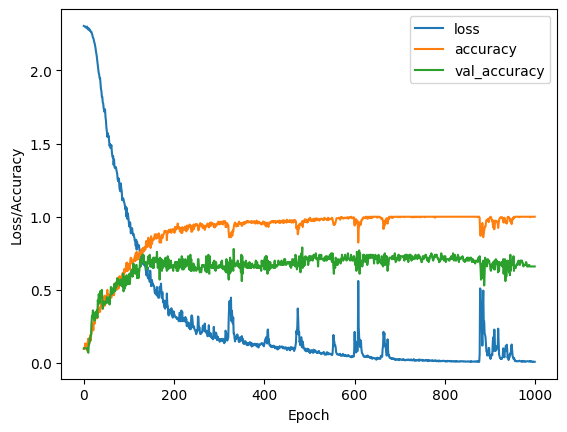

In [17]:
pd.DataFrame.from_dict(result.history)[["loss", "accuracy", "val_accuracy"]].plot()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")

In [34]:
predictions = model.predict(test_features)
predictions_category_id = [i.argmax() for i in predictions]

2023-09-01 20:06:25.850433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-01 20:06:25.851368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-01 20:06:25.852062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 1s 47ms/step


In [35]:
df_predictions = pd.DataFrame.from_dict({"category": test_target, "prediction": predictions_category_id})
df_predictions["correct"] = df_predictions["category"] == df_predictions["prediction"]
df_predictions

,category,prediction,correct
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True
...,...,...,...
95,9,6,False
96,9,9,True
97,9,9,True
98,9,9,True


Text(0, 0.5, 'Prediction')

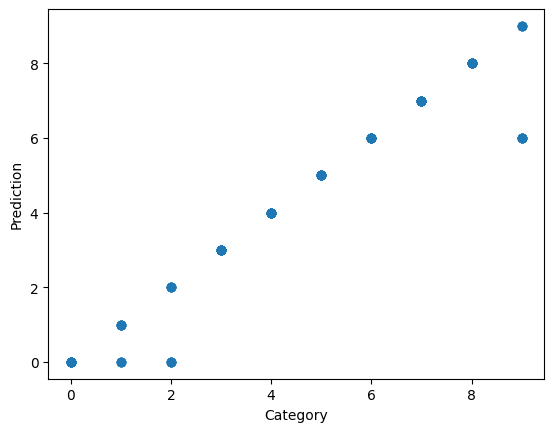

In [36]:
plt.scatter(x=df_predictions["category"], y=df_predictions["prediction"])
plt.xlabel("Category")
plt.ylabel("Prediction")

In [37]:
categories = df_predictions["category"].unique()
categories.sort()
for category in categories:
    df_category = df_predictions[df_predictions["category"] == category]
    correct = len(df_category[df_category["correct"] == True])
    count = len(df_category)
    print(category)
    print("Correct:", correct)
    print("Wrong:", count - correct)
    print("Precision:", correct/count * 100)
    print()

0
Correct: 10
Wrong: 0
Precision: 100.0

1
Correct: 6
Wrong: 4
Precision: 60.0

2
Correct: 5
Wrong: 5
Precision: 50.0

3
Correct: 10
Wrong: 0
Precision: 100.0

4
Correct: 10
Wrong: 0
Precision: 100.0

5
Correct: 10
Wrong: 0
Precision: 100.0

6
Correct: 10
Wrong: 0
Precision: 100.0

7
Correct: 10
Wrong: 0
Precision: 100.0

8
Correct: 10
Wrong: 0
Precision: 100.0

9
Correct: 4
Wrong: 6
Precision: 40.0



In [42]:
# Validation
validation_data = pd.read_csv("validate_dataset.csv")

In [43]:
validation_data

,Unnamed: 0,category,video_name,frame,hand_0_wrist_x,hand_0_wrist_y,hand_0_wrist_z,hand_0_thumb_cmc_x,hand_0_thumb_cmc_y,hand_0_thumb_cmc_z,...,pose_right_heel_z,pose_left_heel_x,pose_left_heel_y,pose_left_heel_z,pose_right_foot_index_x,pose_right_foot_index_y,pose_right_foot_index_z,pose_left_foot_index_x,pose_left_foot_index_y,pose_left_foot_index_z
0,0,0,hello.mp4,0,0.778732,0.533119,1.618656e-07,0.760882,0.535324,-0.018034,...,0.395898,0.572077,0.911452,0.501065,0.719199,0.972017,0.119681,0.488783,0.955139,0.242829
1,1,0,hello.mp4,1,0.780349,0.531990,2.006781e-07,0.765526,0.535483,-0.019550,...,0.411669,0.572511,0.911294,0.488532,0.719056,0.971016,0.124615,0.489077,0.955218,0.222932
2,2,0,hello.mp4,2,0.789860,0.532102,1.953509e-07,0.769175,0.535249,-0.012909,...,0.398743,0.574021,0.911196,0.440281,0.718746,0.970221,0.106521,0.489621,0.955267,0.175936
3,3,0,hello.mp4,3,0.788924,0.532276,2.103518e-07,0.768380,0.534756,-0.015882,...,0.436644,0.574857,0.911146,0.453911,0.718660,0.969597,0.106942,0.489658,0.955268,0.162054
4,4,0,hello.mp4,4,0.349383,0.268837,4.599055e-10,0.370172,0.267407,-0.015195,...,0.501966,0.575456,0.910632,0.530033,0.716889,0.969052,0.172926,0.490454,0.955318,0.231649
5,5,0,hello.mp4,5,0.785580,0.531081,2.303617e-07,0.761963,0.533857,-0.015278,...,0.544538,0.575521,0.909889,0.595152,0.716690,0.969041,0.227990,0.491607,0.955701,0.317404
6,6,0,hello.mp4,6,0.441508,0.162445,1.070640e-07,0.467898,0.163019,-0.007401,...,0.521477,0.575575,0.909088,0.603336,0.715843,0.969006,0.203265,0.492571,0.955709,0.331097
7,7,0,hello.mp4,7,0.465447,0.166934,1.335545e-07,0.497158,0.169014,-0.003429,...,0.531344,0.575584,0.907475,0.638983,0.714891,0.969012,0.206211,0.493177,0.955663,0.364467
8,8,0,hello.mp4,8,0.471391,0.166036,1.390416e-07,0.500977,0.170404,-0.007057,...,0.523898,0.574160,0.907230,0.632156,0.714896,0.969352,0.198824,0.493277,0.955528,0.354292
9,9,0,hello.mp4,9,0.464834,0.160303,1.670441e-07,0.493160,0.164720,-0.007812,...,0.560217,0.573337,0.907003,0.647405,0.714541,0.969358,0.225727,0.493262,0.955509,0.362772


In [44]:
validation_data = validation_data.drop(["Unnamed: 0", "category", "video_name", "frame"], axis=1).values

In [45]:
validation_data = validation_data.reshape((int(validation_data.shape[0]/frames), frames, validation_data.shape[1]))

In [46]:
validation_data.shape

(1, 30, 1623)

In [47]:
result = model.predict(validation_data)

1/1 [==============================] - 0s 17ms/step


In [50]:
result.argmax()

3